<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/04_convolution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Machine Learning Model: Convolutional Neural Network**

| | |
|------|------|
| Filename | 04_convolution_CNN.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 10, 2024 |
| Aim(s) | Classify images with a simple convolutional neural network |
| Dataset(s) | Flower API Google dataset [[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) |
| Version | Python 3.10.12 - TensorFlow 2.17.1 |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

A convolutional neural network (CNN) model is created and trained in this Python script. The objective is to classify 5 different flower classes from the Google API flower dataset.

#### **Outline**
* retrieve data & data augmentation
* CNN model
* training & evaluation
* predictions
* references

---


### **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'

In [2]:
# @title **1. Python librairies & display utilities [RUN ME]**

import numpy as np
import os
from PIL import Image # image processing capabilities
from tensorflow import keras, data, expand_dims, nn
from keras import layers, utils, Sequential, Input, losses, callbacks
from pandas import DataFrame
import matplotlib.pyplot as plt

""" ############################################# """
""" Import Github files from TensorFlow repertory """
""" ############################################# """
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  training_curves_1 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph.jpeg")
  training_curves_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph_OF.jpeg")
  model = keras.models.load_model('TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/04_convolution_CNN.h5')
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves_1, training_curves_2, model

""" ############################################## """
""" Import Github photos from TensorFlow repertory """
""" ############################################## """
def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # go to the Github repertory TensorFlow and clone it
  tulip = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg") # see section 3
  rose = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg") # see section 3
  daisy = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg") # see section 3
  sunflowers = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg") # see section 3
  bouquet = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg") # see section 3
  bouquet_2 = Image.open("TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet_2.jpeg") # see section 3
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return tulip, rose, daisy, sunflowers, bouquet, bouquet_2

""" ################################## """
""" Plot image with the label as title """
""" ################################## """
def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

""" ######################################################### """
""" plot training curves for the training and validation set  """
""" ######################################################### """
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  plt.subplot(2,1,1, ylabel='loss')
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10), plt.grid(True, linestyle='--', alpha=0.6)

  plt.subplot(2,1,2, xlabel='epoch', ylabel='accuracy')
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.grid(True, linestyle='--', alpha=0.6)

---


### **2. Retrieve data and batch generation**

###### **2.1. Retrieve data**

The Google API flower dataset is composed of 3,670 photos of flowers labelled in 5 classes: daisy, dandelion, roses, sunflowers, tulips. The dataset is extracted and placed in the main_directory `flower_dataset` as follows: <br>

**flower_dataset/** <br>
. . . flower_photos/ <br>
. . . . . . daisy/ <br>
. . . . . . . . . *daisy_image1.jpg* <br>
. . . . . . . . . *daisy_image2.jpg* <br>
. . . . . . . . . ... <br>
. . . . . . dandelion/ <br>
. . . . . . . . . *dandelion_image1.jpg* <br>
. . . . . . . . . ...


In [3]:
def get_data(url, batch_size, height, width, validation_ratio):
  folder_name = 'flower_dataset'
  data_dir = utils.get_file(folder_name, dataset_url, untar=True)
  data_dir = os.path.join(data_dir, 'flower_photos')

  train_ds = utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="training", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  val_ds = utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="validation", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  class_names = train_ds.class_names
  return train_ds, val_ds, class_names

The original dataset is split into 3 subsets: the training (80%), validation (16%) and test (4%). The last two sets are created from a fraction of 20% of the original set.

To create subset batches, the utility `image_dataset_from_directory` is used. The test set is then created from the validation test

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

batch_size, img_height, img_width = 32, 180, 180
validation_split = 0.2 # first split used to create the final validation set and test set

train_ds, val_ds, class_names = get_data(dataset_url, batch_size, img_height, img_width, validation_split)

Using 2936 files for training.
Using 734 files for validation.


In [5]:
val_ds_batch_number = data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_ds_batch_number // 5) # create a test set from 20% of the validation set
val_ds = val_ds.skip(val_ds_batch_number // 5)

print("Set details: \nTraining set .... %d batches of %d elements each" %(data.experimental.cardinality(train_ds), batch_size),
      "\nValidation set .. %d batches of %d elements each" %(data.experimental.cardinality(val_ds), batch_size),
      "\nTest set ........ %d batches of %d elements each" %(data.experimental.cardinality(test_ds), batch_size))

Set details: 
Training set .... 92 batches of 32 elements each 
Validation set .. 19 batches of 32 elements each 
Test set ........ 4 batches of 32 elements each


###### **2.2. Performance data configuration**

To improve the performance of the input pipeline, the data is stored in a cache so as to avoid re-opening and re-reading it at each training step. Data batches are also opened, read and transformed successively in background with a prefetch buffer size computed by `AUTOTUNE`.

In [6]:
AUTOTUNE = data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

###### **2.3. Data inspection**

Elements of this database are very varied and rather noisy (presence of decorative elements, human, grave...).

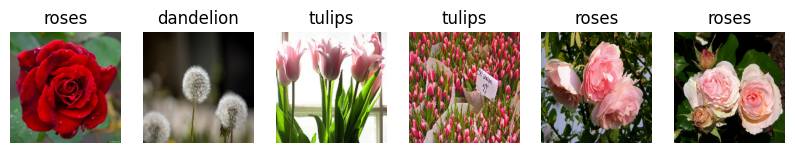

In [7]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  tensor_images, tensor_labels = images, labels # save images/labels for 3.1
  for i in range(6):
    plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

---


### **3. Model and training**

###### **3.1. Data augmentation**

The limited number of training elements given to the model doesn't lead to satisfactory performances. A risk of over-fitting is possible. The graph in section 3.4 shows a poor generalization of performance. Realistic transformations (rotation, flip & zoom) are then applied to the training data to diversify the data set.

In [8]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
outputs = layers.RandomZoom(0.1)(x)

data_augmentation = keras.Model(inputs=inputs, outputs=outputs, name="data_augmentation_layer")

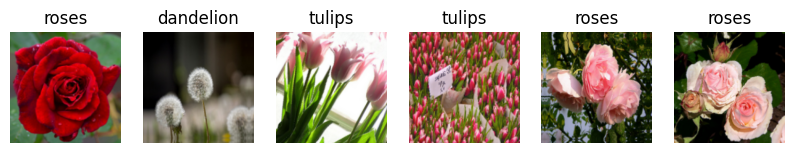

In [9]:
plt.figure(figsize=(10, 8))
images_modified = data_augmentation(tensor_images) # apply to the example set
for i in range(6):
  plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[tensor_labels[i]])

###### **3.2. Model definition**

The model is composed of a series of convolution/pooling layers to extract features/patterns from the input data. A classification model is then implemented to compute logit scores in output.

The neural network architecture is optimized to maximize the number of filters created by the last layer for a sufficient number of weights.  Thus, a series of 5 layers with 16 filters for the initial layer and doubled at each upper layer leads here to a total number of weights of less than 1.3 million and 1064 filters at the input of the classification model.

Here's an overview of the model's architecture at the start:

>* `Input` & `Rescaling` layers:
  * **Inputs & Outputs:** a 3D tensor (`img_height`, `img_width`, `3`)

>* First `Conv2D` layer:
  * **Outputs:** (`img_height`, `img_width`, `filters=16`)
  * **Comments:** `padding = 'same'` so the size of images processed is preserved

>* First `MaxPooling2D` layer:
  * **Outputs:** (`img_height/2`, `img_width/2`, `filters=16`)
  * **Comments:** the maximum 2x2 value is retained

>* . . .

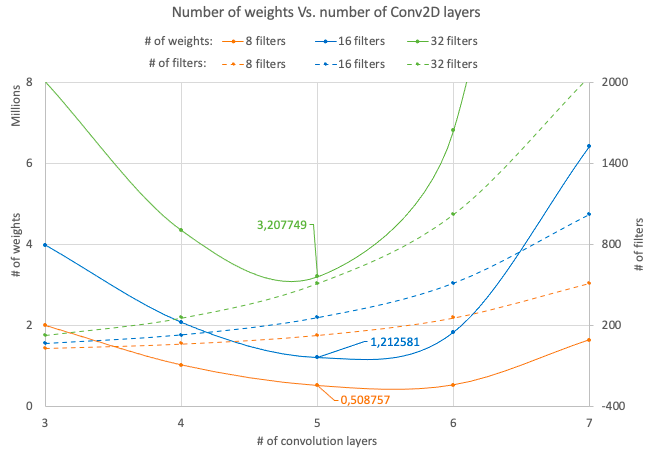

In [10]:
def create_model():
  nb_classes = len(class_names)

  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = data_augmentation(x)
  x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(nb_classes)(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="classifier_CNN")

  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
  return model

###### **3.3. Model training**

The file is saved in .h5 format without the optimizer parameters, as the model can reach a very large number of parameters and therefore generate a large save file. The .h5 format without optimizer parameters requires the model to be recompiled once loaded.

In [11]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early], **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

In [12]:
model = create_model()
epochs = 2

if training_phase == "Yes":
  stop_early = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True, min_delta=0.001)
  classifier_accuracy = train_model(model, train_ds, val_ds, epochs=epochs)
  model.save('04_convolution_CNN.h5', include_optimizer=False) # save file with .h5 format and without optimizer parameters
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))
else:
  training_curves, training_curves_overfitting, model = get_github_files()
  model.compile(optimizer='adam',                                                   # recompilation of the loaded model
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 565 (delta 153), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (565/565), 136.91 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (280/280), done.


###### **3.4. Model evaluation and comments**

A training phase without data augmentation and dropout layer was carried out beforehand and is shown on the training curve plot (right side). The use of data augmentation and layer dropout eliminated the error of over-fitting.

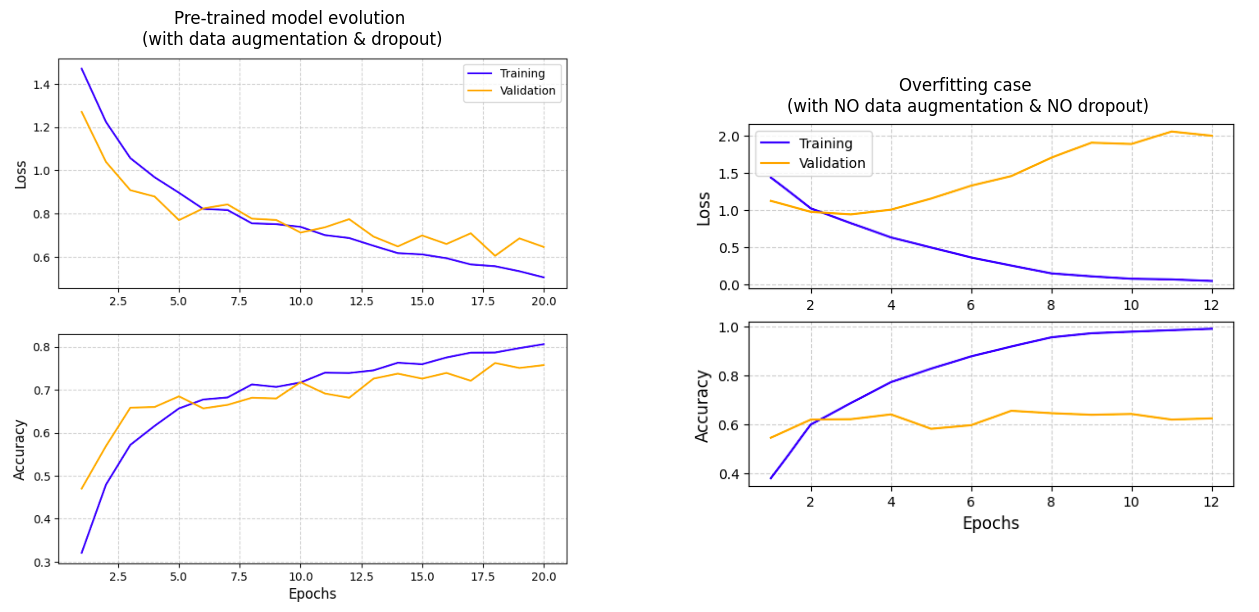

In [13]:
if training_phase == 'Yes':
  plt.figure(figsize=(8, 8))
  plot_evolution(classifier_accuracy)
else:
  plt.figure(figsize=(16, 8))
  plt.subplot(1,2,1, title="Pre-trained model evolution \n(with data augmentation & dropout)")
  plt.imshow(training_curves), plt.axis("off")
  plt.subplot(1,2,2, title="Overfitting case \n(with NO data augmentation & NO dropout)")
  plt.imshow(training_curves_overfitting), plt.axis("off")
  plt.show()

In [14]:
loss_test, accuracy_test = model.evaluate(test_ds, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.5 and test accuracy value 81.2 %


---


### **4. Predictions**

The model can be used to make predictions for flower photos found on Google Image. The softmax function is used to transform the logit scores output by the model into probabilities. 3 out of 4 are correctly recognized.

In [15]:
tulip, rose, daisy, sunflowers, bouquet, bouquet_2 = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 565 (delta 153), reused 94 (delta 94), pack-reused 368 (from 1)
Receiving objects: 100% (565/565), 136.91 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (280/280), done.


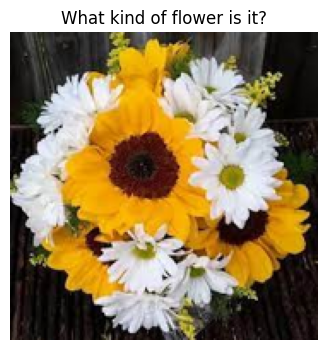

In [16]:
img = bouquet
img = Image.fromarray(np.array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [17]:
resized_img_array = expand_dims(np.array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = nn.softmax(predictions[0])

df = DataFrame(data={'class_names': class_names, 'score': 100*score.numpy()})
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
  class_names      score
0       daisy  74.284760
1   dandelion   2.570698
2       roses   7.271703
3  sunflowers  14.477102
4      tulips   1.395742


The model is also tested on bouquet photos comprising 2 types of flowers. The model's predictions are not as expected: the score is very high for a single type of flower in the bouquet, but the model doesn't seem able to identify any other type of flower.

---


### **5. Conclusions and limitations**

The accuracy of the test set - 80% - and the failure to identify 2 flower types on the same photo, the complexity of the task demands a more robust model, extracting more complex and numerous features.

A possible solution to increase the accuracy of the test set would be to make the feature/pattern extraction model more complex. As the images are noisy due to many external elements (graves, vases, humans, etc.), it is necessary to isolate these features. In the Python Script [05_transfert_learning.ipynb](https://github.com/Benjamin-morel/TensorFlow), the same task is performed, but with a much more complex feature/pattern extraction model.

---


### **6. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) | Flowers Recognition | Alexander Mamaev | dataset | - |
|[[2]](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks) | Convolutional Neural Networks cheatsheet | Afshine Amidi and Shervine Amidi | lecture | - |
|[[3]](https://www.tensorflow.org/tutorials/images/cnn) | Convolutional Neural Network (CNN) | TensorFlow | Tutoriels | - |
|[[4]](https://www.tensorflow.org/tutorials/images/data_augmentation) | Data augmentation | TensorFlow | Tutoriels | - |
|[[5]](https://cs231n.github.io/) | Convolutional Neural Networks for Visual Recognition | Stanford cs231n | lecture | - |